In [242]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [91]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


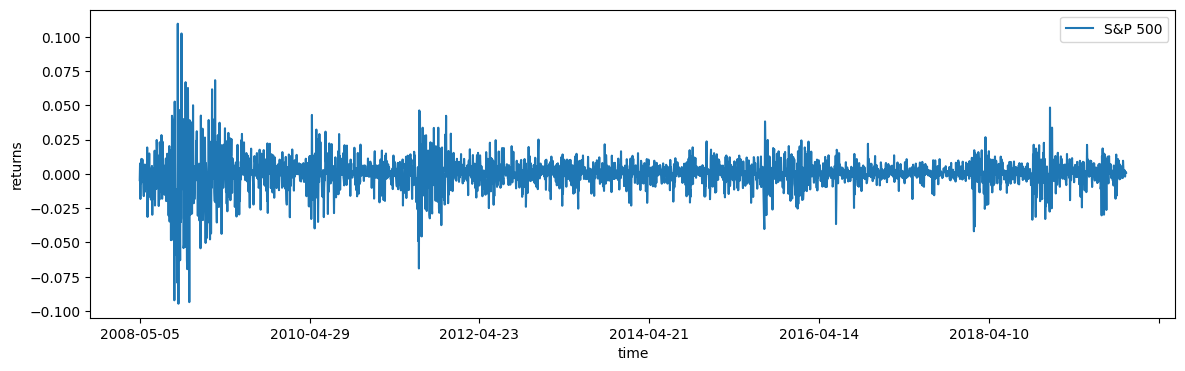

In [80]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [14]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


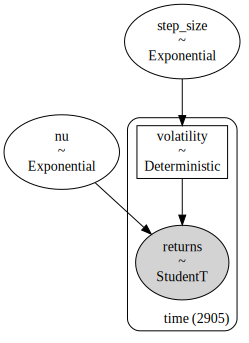

In [15]:
pm.model_to_graphviz(stochastic_vol_model)

In [16]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


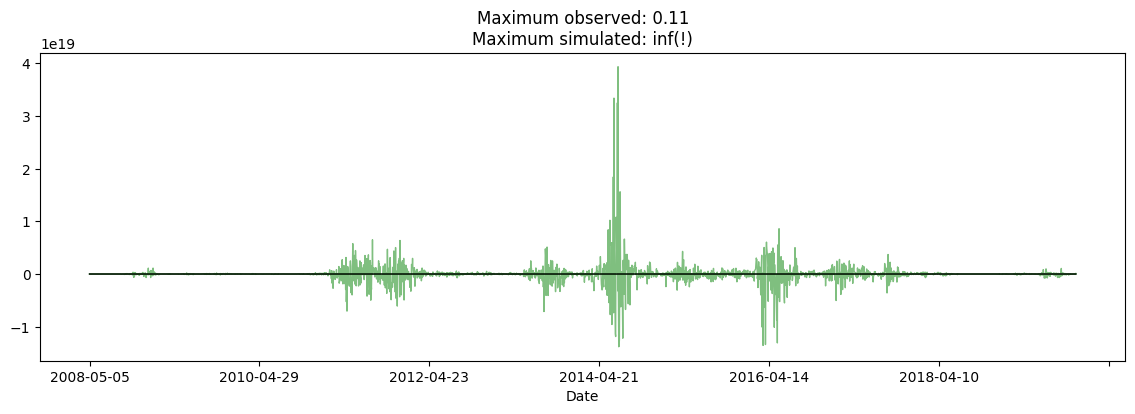

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [15]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 891 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [16]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


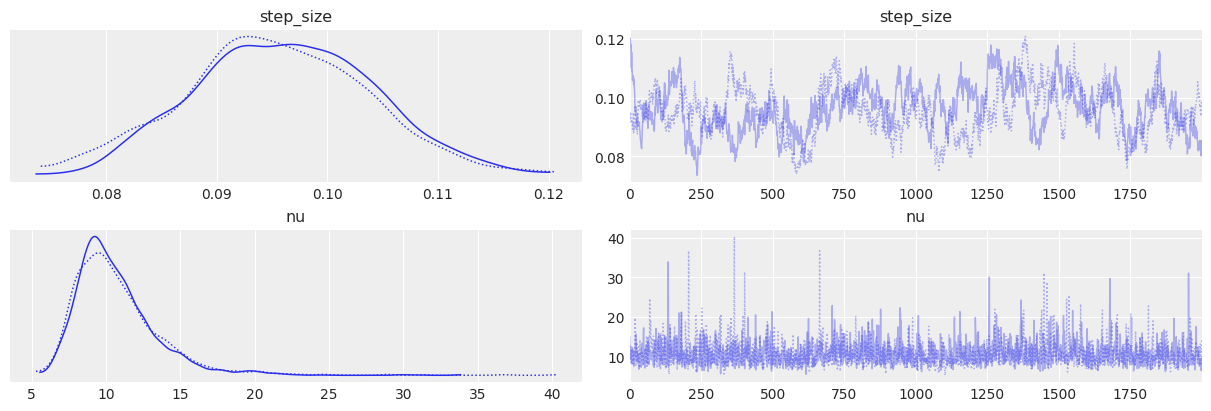

In [17]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

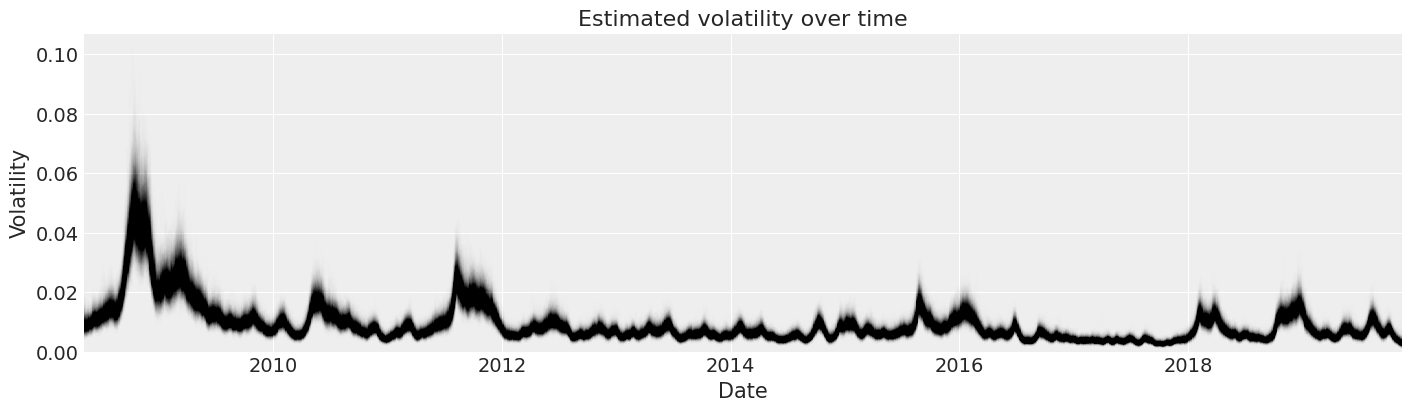

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

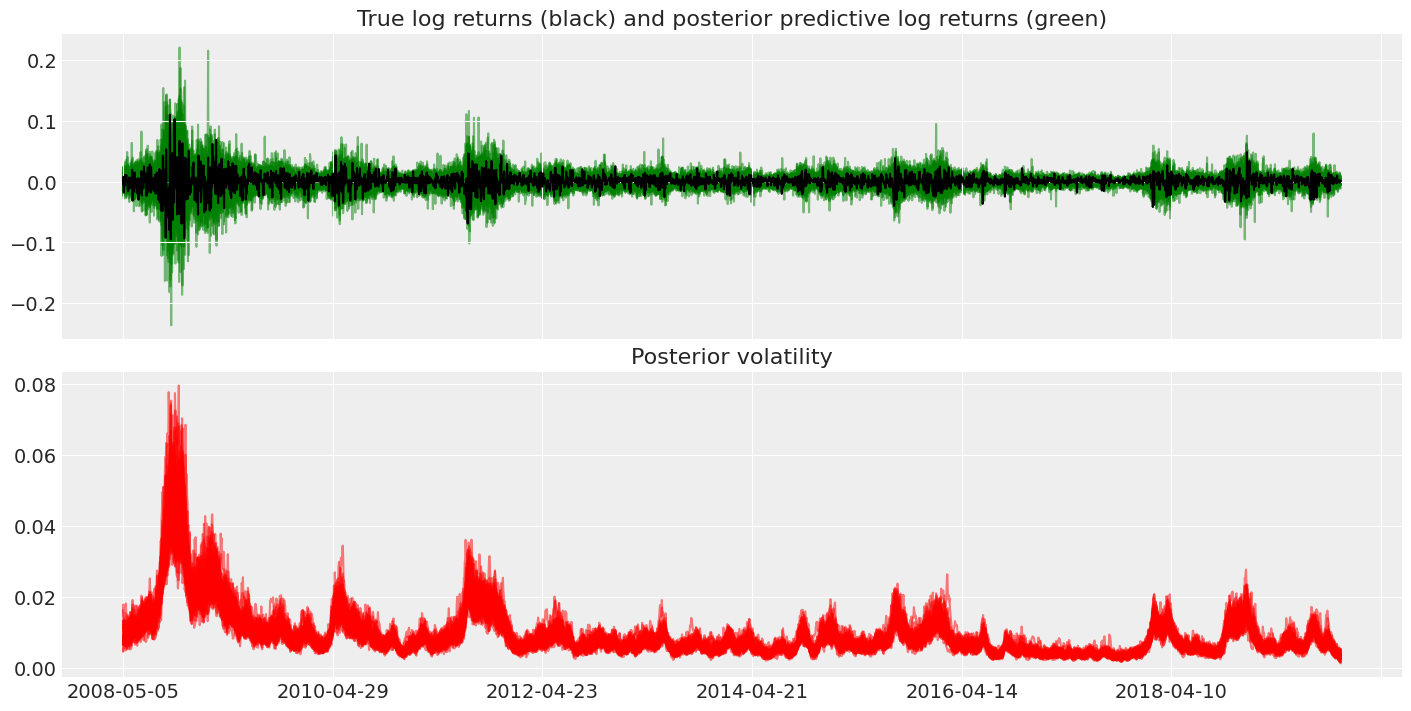

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models

$X_i = log(r_i)$

$
p(s_i, \nu, \sigma | {\bf x}) = [\Pi_ip(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma)
$

In [1476]:
class StochasticVolatility(nn.Module):
    EPSILON = 1e-6
    
    def __init__(self, shape, sigma_lambda=10., nu_lambda=0.1):
        '''
            Args:
                shape: shape of observed variables; first dim is batch_size
                sigma_lamda: rate parameter of Exponential prior RV of stepsize (aka sigma)
                nu_lamda: rate parameter of Exponential prior RV of degree freedom
        '''
        super(StochasticVolatility, self).__init__()
        self.shape = shape
        
        self.prior_sigma_rv = distributions.Exponential(sigma_lambda)
        self.sigma = nn.Parameter(torch.tensor(sigma_lambda))
        
        self.prior_nu_rv = distributions.Exponential(nu_lambda)
        self.nu = nn.Parameter(torch.tensor(nu_lambda))
        
        self.vol = nn.Parameter(torch.zeros(self.shape[1]))
        nn.init.normal_(self.vol, std=0.0001)
        
        self.init_vol = nn.Parameter(torch.tensor(-4.5))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        rv = distributions.StudentT(df=(1 / (self.nu + self.EPSILON)) * torch.ones(vol_samples.shape), 
                                    loc=torch.zeros(vol_samples.shape), 
                                    scale=torch.exp(vol_samples) + EPSILON)
        return rv

    def forward(self):
        vol_rv = distributions.Normal(torch.stack([self.vol] * self.shape[0]),
                                      (1 / self.sigma) * torch.ones(self.shape))
        vol_diffs = vol_rv.rsample()
        vol_samples = self.init_vol + torch.cumsum(vol_diffs, dim=1)
        
        #print(f'* self.shape = {self.shape}')
        print(f'* sigma = {self.sigma}')
        #print(f'* vol = {self.vol}')
        #print(f'* vol_diffs = {vol_diffs}') 
        #print(f'* vol_samples = {vol_samples}, {vol_samples.shape}')
        print(f'* nu = {self.nu}')
        #print(f'* init_vol = {self.init_vol}')
        #print(f'* t-scale = {torch.exp(vol_samples)}')
        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
       
        vol_rv = distributions.Normal(loc=torch.zeros(vol_samples.shape),
                                      scale=(1 / self.sigma) * torch.ones(vol_samples.shape))
        vol_prior = vol_rv.log_prob(self.vol)
       
        # Prior for each timestep
        sigma_prior = self.prior_sigma_rv.log_prob(1 / self.sigma)
        nu_prior = self.prior_nu_rv.log_prob(1 / self.nu)
        
        print(f'll = {likelihood.sum():.3f}, vol_prior = {vol_prior.sum():.3f}, sigma_prior = {sigma_prior.sum():.3f}, nu_prior = {nu_prior.sum():.3f}')
        return -(likelihood.sum() + vol_prior.sum() + sigma_prior.sum() + nu_prior.sum()) / np.prod(self.shape)

# SGLD

In [1477]:
batch_size = 10

torch_data = torch.tensor(returns['change'])
torch_data = torch.stack([torch_data] * batch_size, 0)

torch_data, torch_data.shape

(tensor([[-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         ...,
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008]],
        dtype=torch.float64),
 torch.Size([10, 2905]))

* sigma = 10.0
* nu = 0.10000000149011612
ll = -426557.653, vol_prior = 40194.914, sigma_prior = 1.303, nu_prior = -3.303
torch_model.sigma.grad = -2.4158737659454346
torch_model.nu.grad = -161.44577026367188
[epoch=1] loss: 13.29999
* sigma = 10.00100040435791
* nu = 0.10100000351667404
ll = -88731.436, vol_prior = 40196.371, sigma_prior = 1.303, nu_prior = -3.293
torch_model.sigma.grad = -0.7987028360366821
torch_model.nu.grad = -31.390127182006836
[epoch=2] loss: 1.67081
* sigma = 10.001870155334473
* nu = 0.10179982334375381
ll = -2488.809, vol_prior = 40196.148, sigma_prior = 1.303, nu_prior = -3.285
torch_model.sigma.grad = -0.35597485303878784
torch_model.nu.grad = -2.6518797874450684
[epoch=3] loss: -1.29795
* sigma = 10.00262451171875
* nu = 0.10242831707000732
ll = -29249.135, vol_prior = 40195.680, sigma_prior = 1.303, nu_prior = -3.279
torch_model.sigma.grad = -0.8501268029212952
torch_model.nu.grad = -11.671845436096191
[epoch=4] loss: -0.37675
* sigma = 10.00339412689209


ll = 16245.126, vol_prior = 40274.852, sigma_prior = 1.305, nu_prior = -3.182
torch_model.sigma.grad = -0.6079515218734741
torch_model.nu.grad = -8.099132537841797
[epoch=39] loss: -1.94555
* sigma = 10.029292106628418
* nu = 0.11403106153011322
ll = 2917.406, vol_prior = 40277.254, sigma_prior = 1.306, nu_prior = -3.180
torch_model.sigma.grad = -0.39043307304382324
torch_model.nu.grad = -1.3741692304611206
[epoch=40] loss: -1.48684
* sigma = 10.030064582824707
* nu = 0.11431349813938141
ll = -53187.207, vol_prior = 40279.641, sigma_prior = 1.306, nu_prior = -3.177
torch_model.sigma.grad = -0.7973489165306091
torch_model.nu.grad = -21.471471786499023
[epoch=41] loss: 0.44439
* sigma = 10.030864715576172
* nu = 0.1146465465426445
ll = -53973.750, vol_prior = 40281.984, sigma_prior = 1.306, nu_prior = -3.175
torch_model.sigma.grad = -0.6982437372207642
torch_model.nu.grad = -21.808374404907227
[epoch=42] loss: 0.47138
* sigma = 10.031679153442383
* nu = 0.11502671986818314
ll = 20816.596

torch_model.sigma.grad = -0.5251559615135193
torch_model.nu.grad = -3.4606971740722656
[epoch=76] loss: 0.42034
* sigma = 10.060721397399902
* nu = 0.1293729692697525
ll = -18961.208, vol_prior = 40359.219, sigma_prior = 1.309, nu_prior = -3.076
torch_model.sigma.grad = -0.19736963510513306
torch_model.nu.grad = -0.7224310040473938
[epoch=77] loss: -0.73653
* sigma = 10.06158447265625
* nu = 0.12980897724628448
ll = -92310.424, vol_prior = 40361.211, sigma_prior = 1.309, nu_prior = -3.073
torch_model.sigma.grad = -1.499432921409607
torch_model.nu.grad = -24.35524559020996
[epoch=78] loss: 1.78833
* sigma = 10.062541961669922
* nu = 0.13030502200126648
ll = -34922.929, vol_prior = 40362.617, sigma_prior = 1.309, nu_prior = -3.070
torch_model.sigma.grad = -0.18429258465766907
torch_model.nu.grad = -0.2804923951625824
[epoch=79] loss: -0.18719
* sigma = 10.063433647155762
* nu = 0.13075561821460724
ll = -2916.827, vol_prior = 40364.602, sigma_prior = 1.309, nu_prior = -3.067
torch_model.s

ll = -30383.231, vol_prior = 40450.684, sigma_prior = 1.312, nu_prior = -2.995
torch_model.sigma.grad = -0.5643289685249329
torch_model.nu.grad = -3.367648124694824
[epoch=115] loss: -0.34650
* sigma = 10.092414855957031
* nu = 0.1448804885149002
ll = -44967.108, vol_prior = 40452.262, sigma_prior = 1.312, nu_prior = -2.993
torch_model.sigma.grad = -1.0636755228042603
torch_model.nu.grad = -15.99950885772705
[epoch=116] loss: 0.15547
* sigma = 10.093329429626465
* nu = 0.14535190165042877
ll = -41302.801, vol_prior = 40453.477, sigma_prior = 1.312, nu_prior = -2.991
torch_model.sigma.grad = -0.8595186471939087
torch_model.nu.grad = -11.020050048828125
[epoch=117] loss: 0.02929
* sigma = 10.094267845153809
* nu = 0.14583054184913635
ll = -33931.769, vol_prior = 40454.473, sigma_prior = 1.312, nu_prior = -2.988
torch_model.sigma.grad = -0.33369553089141846
torch_model.nu.grad = -0.3281254470348358
[epoch=118] loss: -0.22448
* sigma = 10.095160484313965
* nu = 0.14626485109329224
ll = -50

torch_model.sigma.grad = -0.5692201852798462
torch_model.nu.grad = -6.6144328117370605
[epoch=152] loss: -1.45125
* sigma = 10.122462272644043
* nu = 0.159342423081398
ll = 14999.961, vol_prior = 40537.621, sigma_prior = 1.315, nu_prior = -2.930
torch_model.sigma.grad = -0.4837476313114166
torch_model.nu.grad = -3.2239465713500977
[epoch=153] loss: -1.91174
* sigma = 10.12315845489502
* nu = 0.15963725745677948
ll = 24363.156, vol_prior = 40540.055, sigma_prior = 1.315, nu_prior = -2.929
torch_model.sigma.grad = -0.6467614769935608
torch_model.nu.grad = -10.4013032913208
[epoch=154] loss: -2.23413
* sigma = 10.12387752532959
* nu = 0.1599590927362442
ll = -2984.150, vol_prior = 40542.168, sigma_prior = 1.315, nu_prior = -2.928
torch_model.sigma.grad = -0.5283713936805725
torch_model.nu.grad = -5.000579357147217
[epoch=155] loss: -1.29282
* sigma = 10.124601364135742
* nu = 0.1602766215801239
ll = -20768.467, vol_prior = 40544.242, sigma_prior = 1.315, nu_prior = -2.927
torch_model.sigm

torch_model.sigma.grad = -0.7468860149383545
torch_model.nu.grad = -10.620614051818848
[epoch=190] loss: -0.79945
* sigma = 10.152685165405273
* nu = 0.17392493784427643
ll = 17055.699, vol_prior = 40621.484, sigma_prior = 1.318, nu_prior = -2.878
torch_model.sigma.grad = -0.3731114864349365
torch_model.nu.grad = -2.027040481567383
[epoch=191] loss: -1.98539
* sigma = 10.153531074523926
* nu = 0.1743549406528473
ll = 6872.790, vol_prior = 40623.543, sigma_prior = 1.318, nu_prior = -2.876
torch_model.sigma.grad = -0.33718377351760864
torch_model.nu.grad = -1.0236765146255493
[epoch=192] loss: -1.63493
* sigma = 10.154343605041504
* nu = 0.17474904656410217
ll = -89046.022, vol_prior = 40625.805, sigma_prior = 1.318, nu_prior = -2.875
torch_model.sigma.grad = -1.0372892618179321
torch_model.nu.grad = -16.165771484375
[epoch=193] loss: 1.66684
* sigma = 10.155223846435547
* nu = 0.17519843578338623
ll = -27231.554, vol_prior = 40628.031, sigma_prior = 1.318, nu_prior = -2.873
torch_model.

ll = -80518.233, vol_prior = 40714.242, sigma_prior = 1.321, nu_prior = -2.829
torch_model.sigma.grad = -0.8076059818267822
torch_model.nu.grad = -9.315535545349121
[epoch=229] loss: 1.37024
* sigma = 10.186941146850586
* nu = 0.1903706043958664
ll = 6862.847, vol_prior = 40717.266, sigma_prior = 1.321, nu_prior = -2.828
torch_model.sigma.grad = -0.37727952003479004
torch_model.nu.grad = -1.933598518371582
[epoch=230] loss: -1.63782
* sigma = 10.187768936157227
* nu = 0.19074647128582
ll = -58798.052, vol_prior = 40720.195, sigma_prior = 1.321, nu_prior = -2.827
torch_model.sigma.grad = -0.8051063418388367
torch_model.nu.grad = -9.082653045654297
[epoch=231] loss: 0.62235
* sigma = 10.188632011413574
* nu = 0.191142275929451
ll = -46333.214, vol_prior = 40723.020, sigma_prior = 1.321, nu_prior = -2.826
torch_model.sigma.grad = -0.8468212485313416
torch_model.nu.grad = -9.649378776550293
[epoch=232] loss: 0.19317
* sigma = 10.189533233642578
* nu = 0.19155965745449066
ll = -6254.681, vo

torch_model.sigma.grad = -0.25975701212882996
torch_model.nu.grad = -0.4032972753047943
[epoch=267] loss: -2.10831
* sigma = 10.219765663146973
* nu = 0.2064073085784912
ll = -38271.689, vol_prior = 40808.520, sigma_prior = 1.324, nu_prior = -2.787
torch_model.sigma.grad = -0.6298785209655762
torch_model.nu.grad = -9.559045791625977
[epoch=268] loss: -0.08728
* sigma = 10.220621109008789
* nu = 0.206893190741539
ll = 12426.537, vol_prior = 40810.508, sigma_prior = 1.324, nu_prior = -2.786
torch_model.sigma.grad = -0.36918824911117554
torch_model.nu.grad = -2.223653554916382
[epoch=269] loss: -1.83255
* sigma = 10.221446990966797
* nu = 0.2073460966348648
ll = -30963.852, vol_prior = 40812.637, sigma_prior = 1.324, nu_prior = -2.785
torch_model.sigma.grad = -0.5769398212432861
torch_model.nu.grad = -3.846223831176758
[epoch=270] loss: -0.33898
* sigma = 10.222277641296387
* nu = 0.20778000354766846
ll = -49765.743, vol_prior = 40814.902, sigma_prior = 1.324, nu_prior = -2.784
torch_mode

torch_model.sigma.grad = -0.4381713569164276
torch_model.nu.grad = -4.140372276306152
[epoch=305] loss: -2.44664
* sigma = 10.250523567199707
* nu = 0.2210473120212555
ll = 5256.891, vol_prior = 40896.133, sigma_prior = 1.327, nu_prior = -2.755
torch_model.sigma.grad = -0.47711387276649475
torch_model.nu.grad = -5.6775641441345215
[epoch=306] loss: -1.58870
* sigma = 10.251314163208008
* nu = 0.22141002118587494
ll = 129.857, vol_prior = 40898.383, sigma_prior = 1.327, nu_prior = -2.754
torch_model.sigma.grad = -0.5733380913734436
torch_model.nu.grad = -7.2704057693481445
[epoch=307] loss: -1.41228
* sigma = 10.252113342285156
* nu = 0.2217879742383957
ll = 9749.129, vol_prior = 40900.703, sigma_prior = 1.327, nu_prior = -2.753
torch_model.sigma.grad = -0.40589603781700134
torch_model.nu.grad = -1.253714680671692
[epoch=308] loss: -1.74349
* sigma = 10.252896308898926
* nu = 0.22213758528232574
ll = -88648.253, vol_prior = 40902.969, sigma_prior = 1.327, nu_prior = -2.753
torch_model.s

ll = -40355.599, vol_prior = 40973.496, sigma_prior = 1.330, nu_prior = -2.725
torch_model.sigma.grad = -0.5943923592567444
torch_model.nu.grad = -10.76108169555664
[epoch=343] loss: -0.02122
* sigma = 10.281200408935547
* nu = 0.2371128350496292
ll = -19318.782, vol_prior = 40974.199, sigma_prior = 1.330, nu_prior = -2.724
torch_model.sigma.grad = -0.25959691405296326
torch_model.nu.grad = -0.1142195612192154
[epoch=344] loss: -0.74541
* sigma = 10.282020568847656
* nu = 0.23754341900348663
ll = 7182.783, vol_prior = 40975.570, sigma_prior = 1.330, nu_prior = -2.724
torch_model.sigma.grad = -0.40948885679244995
torch_model.nu.grad = -2.519786834716797
[epoch=345] loss: -1.65773
* sigma = 10.28282356262207
* nu = 0.23795011639595032
ll = -17305.042, vol_prior = 40977.148, sigma_prior = 1.330, nu_prior = -2.723
torch_model.sigma.grad = -0.20354866981506348
torch_model.nu.grad = 0.13090527057647705
[epoch=346] loss: -0.81483
* sigma = 10.283578872680664
* nu = 0.23831580579280853
ll = -1

* sigma = 10.312605857849121
* nu = 0.25317618250846863
ll = 18974.264, vol_prior = 41064.344, sigma_prior = 1.333, nu_prior = -2.698
torch_model.sigma.grad = -0.2959704101085663
torch_model.nu.grad = -1.3296147584915161
[epoch=384] loss: -2.06669
* sigma = 10.31345272064209
* nu = 0.2535912096500397
ll = 16059.533, vol_prior = 41066.457, sigma_prior = 1.333, nu_prior = -2.697
torch_model.sigma.grad = -0.42158693075180054
torch_model.nu.grad = -2.986515760421753
[epoch=385] loss: -1.96642
* sigma = 10.314282417297363
* nu = 0.2539883553981781
ll = 13726.622, vol_prior = 41068.598, sigma_prior = 1.333, nu_prior = -2.696
torch_model.sigma.grad = -0.4228847026824951
torch_model.nu.grad = -2.7462737560272217
[epoch=386] loss: -1.88619
* sigma = 10.31509780883789
* nu = 0.25436756014823914
ll = -6178.883, vol_prior = 41070.836, sigma_prior = 1.333, nu_prior = -2.696
torch_model.sigma.grad = -0.27313894033432007
torch_model.nu.grad = -0.12099629640579224
[epoch=387] loss: -1.20105
* sigma = 

ll = -10765.006, vol_prior = 41148.434, sigma_prior = 1.336, nu_prior = -2.677
torch_model.sigma.grad = -0.32586586475372314
torch_model.nu.grad = -0.3579147756099701
[epoch=422] loss: -1.04585
* sigma = 10.34372615814209
* nu = 0.2675405740737915
ll = -21732.608, vol_prior = 41149.664, sigma_prior = 1.336, nu_prior = -2.676
torch_model.sigma.grad = -0.400349497795105
torch_model.nu.grad = -1.9484063386917114
[epoch=423] loss: -0.66836
* sigma = 10.344549179077148
* nu = 0.267983615398407
ll = -32371.321, vol_prior = 41151.230, sigma_prior = 1.336, nu_prior = -2.676
torch_model.sigma.grad = -0.5502369999885559
torch_model.nu.grad = -4.803686618804932
[epoch=424] loss: -0.30219
* sigma = 10.345379829406738
* nu = 0.26842162013053894
ll = -8891.748, vol_prior = 41152.984, sigma_prior = 1.336, nu_prior = -2.675
torch_model.sigma.grad = -0.2878493666648865
torch_model.nu.grad = -0.5152837634086609
[epoch=425] loss: -1.11050
* sigma = 10.346175193786621
* nu = 0.26882055401802063
ll = -5562

torch_model.sigma.grad = -0.6728017926216125
torch_model.nu.grad = -5.691291809082031
[epoch=460] loss: -0.14320
* sigma = 10.372876167297363
* nu = 0.28064286708831787
ll = 5590.853, vol_prior = 41232.758, sigma_prior = 1.339, nu_prior = -2.659
torch_model.sigma.grad = -0.49889805912971497
torch_model.nu.grad = -2.858576774597168
[epoch=461] loss: -1.61178
* sigma = 10.373677253723145
* nu = 0.28095024824142456
ll = 885.738, vol_prior = 41235.250, sigma_prior = 1.339, nu_prior = -2.659
torch_model.sigma.grad = -0.5703070163726807
torch_model.nu.grad = -4.737835884094238
[epoch=462] loss: -1.44990
* sigma = 10.374492645263672
* nu = 0.2812672257423401
ll = -63280.603, vol_prior = 41237.680, sigma_prior = 1.339, nu_prior = -2.658
torch_model.sigma.grad = -0.7004416584968567
torch_model.nu.grad = -10.557512283325195
[epoch=463] loss: 0.75884
* sigma = 10.37534236907959
* nu = 0.28164181113243103
ll = 16931.377, vol_prior = 41240.094, sigma_prior = 1.339, nu_prior = -2.658
torch_model.sig

torch_model.sigma.grad = -0.7389516234397888
torch_model.nu.grad = -7.7465925216674805
[epoch=498] loss: -1.24388
* sigma = 10.40427017211914
* nu = 0.29510578513145447
ll = 15182.482, vol_prior = 41319.594, sigma_prior = 1.341, nu_prior = -2.641
torch_model.sigma.grad = -0.46447402238845825
torch_model.nu.grad = -2.672267436981201
[epoch=499] loss: -1.94495
* sigma = 10.405123710632324
* nu = 0.29545921087265015
ll = 26809.999, vol_prior = 41321.891, sigma_prior = 1.342, nu_prior = -2.641
torch_model.sigma.grad = -0.27496832609176636
torch_model.nu.grad = -0.28637468814849854
[epoch=500] loss: -2.34529
* sigma = 10.405938148498535
* nu = 0.295780211687088
ll = 15948.380, vol_prior = 41324.293, sigma_prior = 1.342, nu_prior = -2.641
torch_model.sigma.grad = -0.4319422245025635
torch_model.nu.grad = -2.545677423477173
[epoch=501] loss: -1.97148
* sigma = 10.406744003295898
* nu = 0.29609182476997375
ll = 14369.705, vol_prior = 41326.680, sigma_prior = 1.342, nu_prior = -2.640
torch_mode

ll = 25964.325, vol_prior = 41401.656, sigma_prior = 1.344, nu_prior = -2.627
torch_model.sigma.grad = -0.2854729890823364
torch_model.nu.grad = -1.071533203125
[epoch=538] loss: -2.31892
* sigma = 10.436076164245605
* nu = 0.3084401786327362
ll = 581.665, vol_prior = 41402.852, sigma_prior = 1.344, nu_prior = -2.627
torch_model.sigma.grad = -0.4174564778804779
torch_model.nu.grad = -2.8807523250579834
[epoch=539] loss: -1.44521
* sigma = 10.43686294555664
* nu = 0.3087804615497589
ll = 3452.075, vol_prior = 41404.297, sigma_prior = 1.344, nu_prior = -2.626
torch_model.sigma.grad = -0.4192034900188446
torch_model.nu.grad = -2.3640336990356445
[epoch=540] loss: -1.54407
* sigma = 10.437643051147461
* nu = 0.3091086745262146
ll = 7370.853, vol_prior = 41405.992, sigma_prior = 1.345, nu_prior = -2.626
torch_model.sigma.grad = -0.3580968677997589
torch_model.nu.grad = -1.658634901046753
[epoch=541] loss: -1.67902
* sigma = 10.438406944274902
* nu = 0.30941957235336304
ll = 21985.082, vol_p

[epoch=576] loss: -0.80655
* sigma = 10.463722229003906
* nu = 0.3205801546573639
ll = 27246.331, vol_prior = 41482.109, sigma_prior = 1.347, nu_prior = -2.615
torch_model.sigma.grad = -0.3594627380371094
torch_model.nu.grad = -0.8027166128158569
[epoch=577] loss: -2.36582
* sigma = 10.464494705200195
* nu = 0.3209604024887085
ll = 31590.331, vol_prior = 41484.383, sigma_prior = 1.347, nu_prior = -2.614
torch_model.sigma.grad = -0.30811256170272827
torch_model.nu.grad = -0.17588505148887634
[epoch=578] loss: -2.51544
* sigma = 10.46524429321289
* nu = 0.32130467891693115
ll = 36113.171, vol_prior = 41486.508, sigma_prior = 1.347, nu_prior = -2.614
torch_model.sigma.grad = -0.3407021462917328
torch_model.nu.grad = -1.2788608074188232
[epoch=579] loss: -2.67120
* sigma = 10.465978622436523
* nu = 0.3216269910335541
ll = 4782.357, vol_prior = 41488.578, sigma_prior = 1.347, nu_prior = -2.614
torch_model.sigma.grad = -0.4688062369823456
torch_model.nu.grad = -2.084455966949463
[epoch=580] 

[epoch=614] loss: -1.80572
* sigma = 10.49398136138916
* nu = 0.33421409130096436
ll = 25507.502, vol_prior = 41564.102, sigma_prior = 1.350, nu_prior = -2.602
torch_model.sigma.grad = -0.35368648171424866
torch_model.nu.grad = -2.738492488861084
[epoch=615] loss: -2.30879
* sigma = 10.494800567626953
* nu = 0.33457690477371216
ll = -5452.531, vol_prior = 41566.410, sigma_prior = 1.350, nu_prior = -2.601
torch_model.sigma.grad = -0.5407617092132568
torch_model.nu.grad = -5.061645030975342
[epoch=616] loss: -1.24312
* sigma = 10.495633125305176
* nu = 0.33495327830314636
ll = -24135.879, vol_prior = 41568.672, sigma_prior = 1.350, nu_prior = -2.601
torch_model.sigma.grad = -0.6038306951522827
torch_model.nu.grad = -4.489257335662842
[epoch=617] loss: -0.60005
* sigma = 10.496488571166992
* nu = 0.3353363275527954
ll = 3630.351, vol_prior = 41570.953, sigma_prior = 1.350, nu_prior = -2.601
torch_model.sigma.grad = -0.4296025335788727
torch_model.nu.grad = -1.8664240837097168
[epoch=618] 

torch_model.sigma.grad = -0.3560901880264282
torch_model.nu.grad = -0.9474925398826599
[epoch=653] loss: -1.97602
* sigma = 10.526330947875977
* nu = 0.3490791916847229
ll = 20733.313, vol_prior = 41652.633, sigma_prior = 1.353, nu_prior = -2.589
torch_model.sigma.grad = -0.3527323603630066
torch_model.nu.grad = -3.0561869144439697
[epoch=654] loss: -2.14749
* sigma = 10.527100563049316
* nu = 0.34937217831611633
ll = 7528.838, vol_prior = 41654.812, sigma_prior = 1.353, nu_prior = -2.589
torch_model.sigma.grad = -0.49135440587997437
torch_model.nu.grad = -4.650639057159424
[epoch=655] loss: -1.69303
* sigma = 10.527881622314453
* nu = 0.34968316555023193
ll = 26786.569, vol_prior = 41656.914, sigma_prior = 1.353, nu_prior = -2.589
torch_model.sigma.grad = -0.38643157482147217
torch_model.nu.grad = -3.410137176513672
[epoch=656] loss: -2.35602
* sigma = 10.528654098510742
* nu = 0.349997878074646
ll = 39495.142, vol_prior = 41658.941, sigma_prior = 1.353, nu_prior = -2.588
torch_model.

ll = 1469.943, vol_prior = 41730.711, sigma_prior = 1.355, nu_prior = -2.579
torch_model.sigma.grad = -0.5427106618881226
torch_model.nu.grad = -5.3895769119262695
[epoch=691] loss: -1.48707
* sigma = 10.555792808532715
* nu = 0.36172249913215637
ll = 6776.147, vol_prior = 41732.766, sigma_prior = 1.355, nu_prior = -2.579
torch_model.sigma.grad = -0.5423648357391357
torch_model.nu.grad = -6.3162946701049805
[epoch=692] loss: -1.66980
* sigma = 10.556593894958496
* nu = 0.36210310459136963
ll = -4465.746, vol_prior = 41734.980, sigma_prior = 1.355, nu_prior = -2.579
torch_model.sigma.grad = -0.5920032858848572
torch_model.nu.grad = -5.699984073638916
[epoch=693] loss: -1.28289
* sigma = 10.557421684265137
* nu = 0.36250534653663635
ll = -13388.937, vol_prior = 41737.273, sigma_prior = 1.355, nu_prior = -2.578
torch_model.sigma.grad = -0.5320432186126709
torch_model.nu.grad = -8.37101936340332
[epoch=694] loss: -0.97580
* sigma = 10.558262825012207
* nu = 0.36295485496520996
ll = -888.24

ll = 30982.270, vol_prior = 41810.766, sigma_prior = 1.358, nu_prior = -2.570
torch_model.sigma.grad = -0.3931218385696411
torch_model.nu.grad = -1.9259459972381592
[epoch=729] loss: -2.50574
* sigma = 10.585498809814453
* nu = 0.37444210052490234
ll = 15027.651, vol_prior = 41813.000, sigma_prior = 1.358, nu_prior = -2.570
torch_model.sigma.grad = -0.439706027507782
torch_model.nu.grad = -2.9114627838134766
[epoch=730] loss: -1.95661
* sigma = 10.586283683776855
* nu = 0.3747645616531372
ll = 39525.759, vol_prior = 41815.211, sigma_prior = 1.358, nu_prior = -2.569
torch_model.sigma.grad = -0.3726135194301605
torch_model.nu.grad = -3.197261095046997
[epoch=731] loss: -2.79999
* sigma = 10.587058067321777
* nu = 0.37508946657180786
ll = 25905.049, vol_prior = 41817.367, sigma_prior = 1.358, nu_prior = -2.569
torch_model.sigma.grad = -0.4102112650871277
torch_model.nu.grad = -2.2212626934051514
[epoch=732] loss: -2.33119
* sigma = 10.587830543518066
* nu = 0.3754061162471771
ll = -3938.3

ll = 6599.843, vol_prior = 41890.320, sigma_prior = 1.360, nu_prior = -2.562
torch_model.sigma.grad = -0.4447859227657318
torch_model.nu.grad = -2.2144103050231934
[epoch=767] loss: -1.66916
* sigma = 10.615144729614258
* nu = 0.38617783784866333
ll = 35474.799, vol_prior = 41892.512, sigma_prior = 1.361, nu_prior = -2.562
torch_model.sigma.grad = -0.3389546573162079
torch_model.nu.grad = -1.6116498708724976
[epoch=768] loss: -2.66321
* sigma = 10.615923881530762
* nu = 0.38647323846817017
ll = 12569.375, vol_prior = 41894.648, sigma_prior = 1.361, nu_prior = -2.561
torch_model.sigma.grad = -0.3822369873523712
torch_model.nu.grad = -0.662046492099762
[epoch=769] loss: -1.87480
* sigma = 10.616697311401367
* nu = 0.38674670457839966
ll = 28335.071, vol_prior = 41896.711, sigma_prior = 1.361, nu_prior = -2.561
torch_model.sigma.grad = -0.39989492297172546
torch_model.nu.grad = -2.041008710861206
[epoch=770] loss: -2.41758
* sigma = 10.617467880249023
* nu = 0.3870157301425934
ll = -2824.

torch_model.sigma.grad = -0.40864184498786926
torch_model.nu.grad = -2.6197314262390137
[epoch=805] loss: -2.39960
* sigma = 10.645058631896973
* nu = 0.39763548970222473
ll = 40853.200, vol_prior = 41973.359, sigma_prior = 1.363, nu_prior = -2.554
torch_model.sigma.grad = -0.3688454329967499
torch_model.nu.grad = -2.424842357635498
[epoch=806] loss: -2.85113
* sigma = 10.64583683013916
* nu = 0.39792636036872864
ll = 48263.528, vol_prior = 41975.430, sigma_prior = 1.363, nu_prior = -2.554
torch_model.sigma.grad = -0.325799822807312
torch_model.nu.grad = -1.2165902853012085
[epoch=807] loss: -3.10629
* sigma = 10.646598815917969
* nu = 0.3982023298740387
ll = 7449.423, vol_prior = 41977.453, sigma_prior = 1.363, nu_prior = -2.554
torch_model.sigma.grad = -0.47716009616851807
torch_model.nu.grad = -3.0709545612335205
[epoch=808] loss: -1.70140
* sigma = 10.647375106811523
* nu = 0.39848610758781433
ll = 20294.837, vol_prior = 41979.496, sigma_prior = 1.363, nu_prior = -2.554
torch_model

ll = -23820.179, vol_prior = 42053.543, sigma_prior = 1.366, nu_prior = -2.547
torch_model.sigma.grad = -0.6096189618110657
torch_model.nu.grad = -4.490643501281738
[epoch=844] loss: -0.62761
* sigma = 10.675986289978027
* nu = 0.4087892770767212
ll = 49158.496, vol_prior = 42055.969, sigma_prior = 1.366, nu_prior = -2.547
torch_model.sigma.grad = -0.3117886483669281
torch_model.nu.grad = -1.3458707332611084
[epoch=845] loss: -3.13987
* sigma = 10.676779747009277
* nu = 0.409066766500473
ll = 25186.460, vol_prior = 42058.242, sigma_prior = 1.366, nu_prior = -2.547
torch_model.sigma.grad = -0.31057965755462646
torch_model.nu.grad = -0.5815497040748596
[epoch=846] loss: -2.31475
* sigma = 10.677553176879883
* nu = 0.4093236029148102
ll = 31141.151, vol_prior = 42060.594, sigma_prior = 1.366, nu_prior = -2.547
torch_model.sigma.grad = -0.4172542095184326
torch_model.nu.grad = -2.3288474082946777
[epoch=847] loss: -2.51981
* sigma = 10.678328514099121
* nu = 0.4095824658870697
ll = 39688.2

* sigma = 10.707133293151855
* nu = 0.42046669125556946
ll = 9043.078, vol_prior = 42138.234, sigma_prior = 1.369, nu_prior = -2.540
torch_model.sigma.grad = -0.4498612582683563
torch_model.nu.grad = -3.1702218055725098
[epoch=883] loss: -1.76179
* sigma = 10.70798110961914
* nu = 0.4207817316055298
ll = 11672.771, vol_prior = 42140.070, sigma_prior = 1.369, nu_prior = -2.540
torch_model.sigma.grad = -0.4943236708641052
torch_model.nu.grad = -2.3190555572509766
[epoch=884] loss: -1.85238
* sigma = 10.708839416503906
* nu = 0.4210937023162842
ll = 18233.222, vol_prior = 42141.789, sigma_prior = 1.369, nu_prior = -2.540
torch_model.sigma.grad = -0.25795918703079224
torch_model.nu.grad = -0.20225565135478973
[epoch=885] loss: -2.07827
* sigma = 10.709661483764648
* nu = 0.42137715220451355
ll = 2043.551, vol_prior = 42143.938, sigma_prior = 1.369, nu_prior = -2.540
torch_model.sigma.grad = -0.32493340969085693
torch_model.nu.grad = -1.4024244546890259
[epoch=886] loss: -1.52104
* sigma = 

ll = 1452.244, vol_prior = 42217.156, sigma_prior = 1.371, nu_prior = -2.534
torch_model.sigma.grad = -0.4302036166191101
torch_model.nu.grad = -4.8477959632873535
[epoch=920] loss: -1.50321
* sigma = 10.736970901489258
* nu = 0.4320731461048126
ll = -19261.337, vol_prior = 42219.137, sigma_prior = 1.371, nu_prior = -2.534
torch_model.sigma.grad = -0.5029474496841431
torch_model.nu.grad = -7.7256855964660645
[epoch=921] loss: -0.79025
* sigma = 10.737770080566406
* nu = 0.4324534833431244
ll = 43561.923, vol_prior = 42221.508, sigma_prior = 1.371, nu_prior = -2.534
torch_model.sigma.grad = -0.33177220821380615
torch_model.nu.grad = -1.536332368850708
[epoch=922] loss: -2.95292
* sigma = 10.738554000854492
* nu = 0.4328152537345886
ll = 12390.376, vol_prior = 42223.695, sigma_prior = 1.371, nu_prior = -2.534
torch_model.sigma.grad = -0.4024572968482971
torch_model.nu.grad = -3.5937328338623047
[epoch=923] loss: -1.87996
* sigma = 10.739337921142578
* nu = 0.43318596482276917
ll = 6115.9

ll = 42618.485, vol_prior = 42297.211, sigma_prior = 1.374, nu_prior = -2.527
torch_model.sigma.grad = -0.3533463478088379
torch_model.nu.grad = -2.8409836292266846
[epoch=958] loss: -2.92305
* sigma = 10.766825675964355
* nu = 0.44519731402397156
ll = -7282.743, vol_prior = 42299.273, sigma_prior = 1.374, nu_prior = -2.527
torch_model.sigma.grad = -0.497161328792572
torch_model.nu.grad = -5.445899486541748
[epoch=959] loss: -1.20535
* sigma = 10.767619132995605
* nu = 0.4455438554286957
ll = -25950.378, vol_prior = 42301.371, sigma_prior = 1.374, nu_prior = -2.527
torch_model.sigma.grad = -0.41915926337242126
torch_model.nu.grad = -3.8357720375061035
[epoch=960] loss: -0.56282
* sigma = 10.768415451049805
* nu = 0.4459051191806793
ll = 29033.461, vol_prior = 42303.508, sigma_prior = 1.374, nu_prior = -2.527
torch_model.sigma.grad = -0.3854638338088989
torch_model.nu.grad = -2.0336549282073975
[epoch=961] loss: -2.45562
* sigma = 10.769208908081055
* nu = 0.4462566077709198
ll = 39427.

torch_model.sigma.grad = -0.411446213722229
torch_model.nu.grad = -2.2322182655334473
[epoch=995] loss: -2.55404
* sigma = 10.79556941986084
* nu = 0.4567112326622009
ll = 41666.363, vol_prior = 42375.070, sigma_prior = 1.376, nu_prior = -2.522
torch_model.sigma.grad = -0.330575168132782
torch_model.nu.grad = -1.28915274143219
[epoch=996] loss: -2.89295
* sigma = 10.796308517456055
* nu = 0.4570007920265198
ll = -4363.492, vol_prior = 42376.992, sigma_prior = 1.376, nu_prior = -2.521
torch_model.sigma.grad = -0.3931970000267029
torch_model.nu.grad = -0.8761942386627197
[epoch=997] loss: -1.30851
* sigma = 10.797052383422852
* nu = 0.45727312564849854
ll = 10220.976, vol_prior = 42379.047, sigma_prior = 1.376, nu_prior = -2.521
torch_model.sigma.grad = -0.39379408955574036
torch_model.nu.grad = -0.9611296653747559
[epoch=998] loss: -1.81063
* sigma = 10.797800064086914
* nu = 0.45753106474876404
ll = 25686.503, vol_prior = 42380.996, sigma_prior = 1.376, nu_prior = -2.521
torch_model.si

<AxesSubplot: >

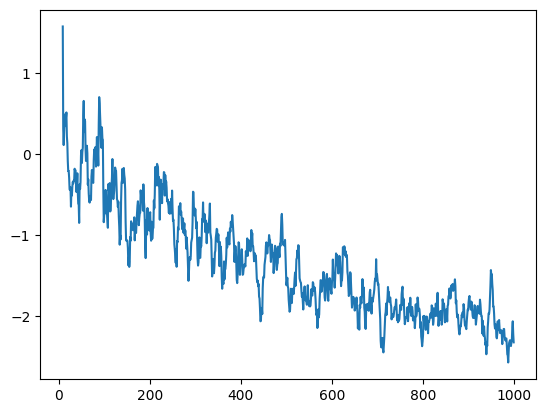

In [1486]:
torch_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
param_group_1 = [p for name, p in torch_model.named_parameters() if name not in {'init_vol', 'sigma', 'nu'}]
param_group_2 = [torch_model.init_vol]
param_group_3 = [torch_model.sigma]
param_group_4 = [torch_model.nu]
optimizer = optim.Adam(torch_model.parameters(), lr=lr)
#optimizer = optim.Adam([{'params': param_group_1},
#                       {'params': param_group_2, 'lr': lr},
#                       {'params': param_group_3, 'lr': lr},
#                       {'params': param_group_4, 'lr': lr / 5},
#                      ],
#                      lr=lr)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

epoch = 0
loss_seq = []
for epoch in range(1000):
    torch_model.zero_grad()
    
    r_samples, vol_samples = torch_model()
    loss = torch_model.loss(torch_data, vol_samples)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(torch_model.sigma, max_norm=50.)
    #torch.nn.utils.clip_grad_norm_(torch_model.vol, max_norm=100.)
    #print(f'torch_model.vol.grad = {torch_model.vol.grad}')
    print(f'torch_model.sigma.grad = {torch_model.sigma.grad}')
    print(f'torch_model.nu.grad = {torch_model.nu.grad}')
    #print(f'torch_model.init_vol.grad = {torch_model.init_vol.grad}')
        
    optimizer.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
    print(f'========================================')
    loss_seq.append(loss.item())
        
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')
    if name in {'sigma', 'nu'}:
        print(f' * 1 / {name} = {1 / param}')

loss_seq = pd.Series(loss_seq)
loss_seq.rolling(10).mean().plot()

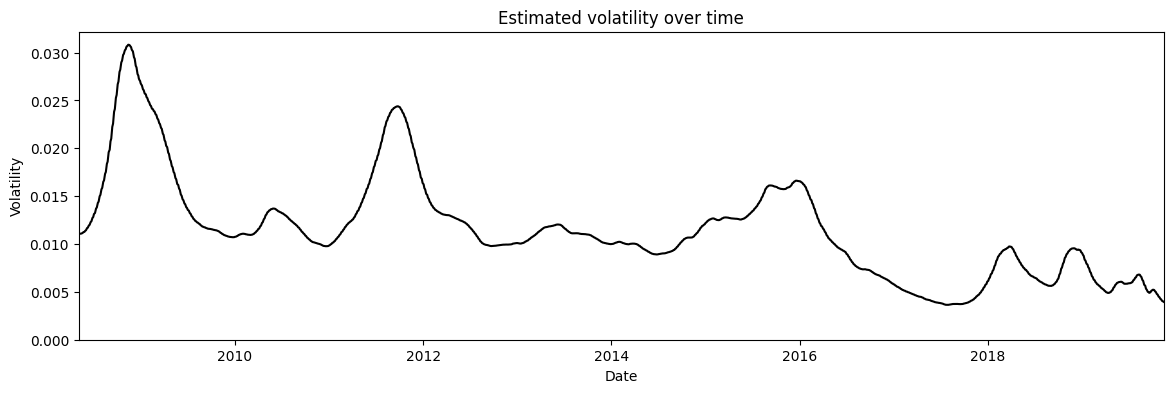

In [1487]:
sigma_rv = distributions.Exponential(torch_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = torch_model.init_vol + torch.cumsum(torch_model.vol, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

# 2022-10-30

* I realized `nu` was off because it close to 2 (instead of the MAP in the model which is around 10)
* After further investigation, it looks like the mode of the posteriod (MAP estimate) shrinks `sigma` and `nu` (the random variables, not the parameters, which is the inverse) to 0.  So there must be a MODE collapse?
* Actually, this happened after I removed the `rsample()` from `nu` and `sigma`.  Adding them back probably slows the rate of decrease down, but probably not eliminates this effect.
* The priors for sure shrink them down to 0 (exponential distribution)
* It kind of looks like the likelihood also does as well?  
    * It's kind of hard to tell because of the indirection, but it's likely that it's at least true for `nu`, which wants to get "fatter" with a higher `nu`, which makes sense given that volatility is always relatively big and not close to 0.

# 2022-10-29

* Think I fixed it to work with batch updating:
    * Got rid of the superfluous `.expands()`
    * Loss: 
        * Priors operate directly on the parameters (NOT the reparameterized samples)
        * Had a bug where I was not using the diff as a prior (because I was using samples, not parameter values)
    * Use ADAM -- this was really important!  I got something *close* to the shape of HMC once every 10 runs or so.  Switching to ADAM, I pretty much the same shape every time.  It makes sense since the parameters probably have such different gradients due to the long chain, and probably having their own learning rates really makes a big difference.
    
TODO:
* Clean up code
* Move on to try SGLD, probably will need that extension paper where they use RMSProp instead of preconditioning matrix.
    
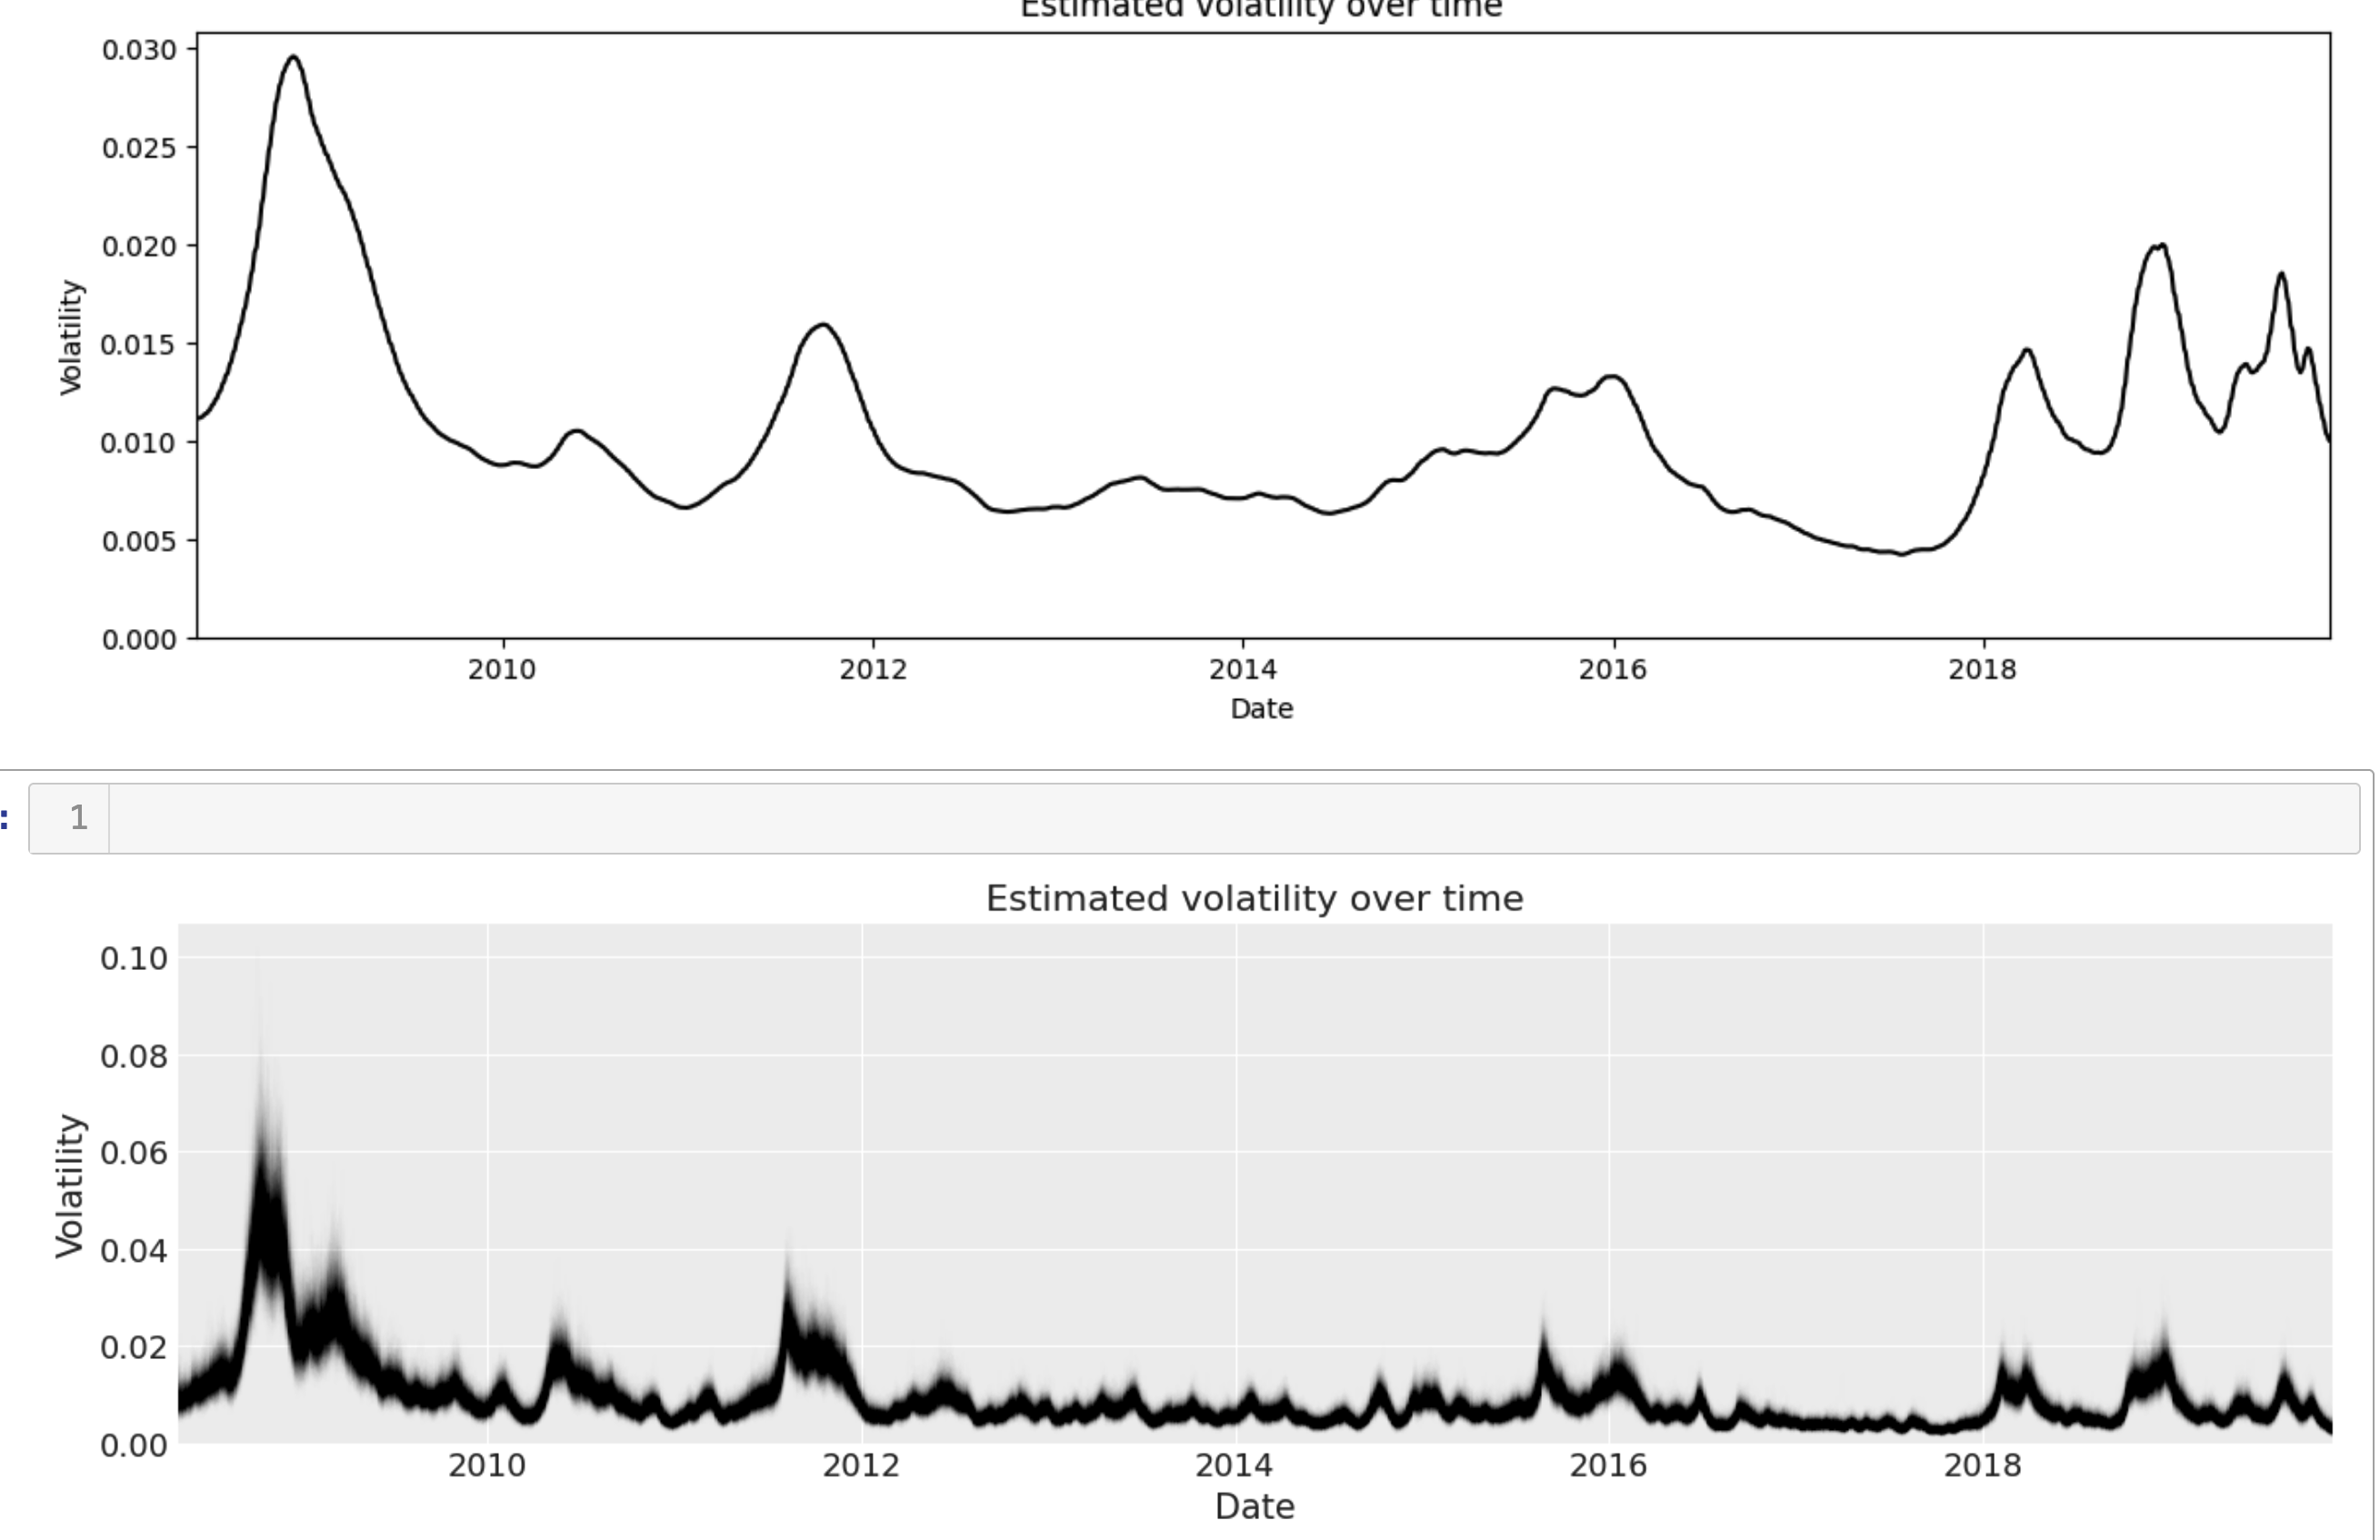


# 2022-10-24

* Fixed up some things in batch implementation, don't use `expand()` because it may have been not back proping through (not sure about that)
    * But using the cleaner method of just using `rsample(sample_size=...)` instead to generate batch needed
* Results still look kind of wrong since I can't mimic the stochastic volatility shape anymore (but the `lambda` and `nu` parameters are very close to the HMC modes / MAP).

TODO:
* Validate each of the batch calculations to make sure I'm generating the right value

# 2022-10-23

* Added `rsample()` to degrees freedom
* With the new changes it gets to the right place... sometimes:
    * There is a lot of variance based on the samples that are drawn from `rsample` and sometimes I get a low-ish loss that is similar in shape, sometimes I get something totally off
* I tried implementing "batch-ing" to average over multiple draws, but it doesn't seem to be learning that fast.

TODO:
* Validate my batch-ing implementation and figure out why it's not learning very fast

# 2022-10-22

* Found another conceptual difference.  I need to sample from each random variable in my DAG using `::rsample()`.
  * So the actual parameters in my torch model are simply the parameters of the random variables (e.g. `sigma` is rate of my exponential step size dist, `self.vol` is mean for the random walk gaussians etc.)
  * So to do a forward pass, I sample from rate, then I sample from vol, then I sample from t-dist (and sample from degrees freedom somewhere)
  * This fixed a lot of issues:
       * We can now backprop all the way through to `self.sigma` instead of only through prior regularizer
       * Misintepreted sigma to be the sample, NOT the rate parameter

TODO:
* Take a look at results in more detail
* May have to do SGD batch-like behavior so that we can smooth the gradient updates (and to smooth the `rsamples`)

# 2022-10-20

* Realized `self.vol` was really just the differences between normal distributions, so the prior can just be evaluated using the $N(0, \sigma^2)$ distribution, simplifying the logic
* I realized the initial value of the Gaussian random walk matters a lot, otherwise there is a discontinuity in the first time step, which throws everything off.  I set it at roughly $log(0.01)$, which is close to the first value I see in the MCMC simulation. 
    * It roughly follows the shape of the posterior from MCMC
    * The scale is off though, most likely because $\sigma$ is very small -- still need to figure out what the deal with that is.
    
    
TODO:
* It also looks like the `vol_init` changes very slowly (along with DF).  Why is that?
    * Is this a case of vanishing gradient (it has to backprop through ~3000 timesteps)?
* Why does $\sigma$ always tend towards negative?  Still need to figure this out...


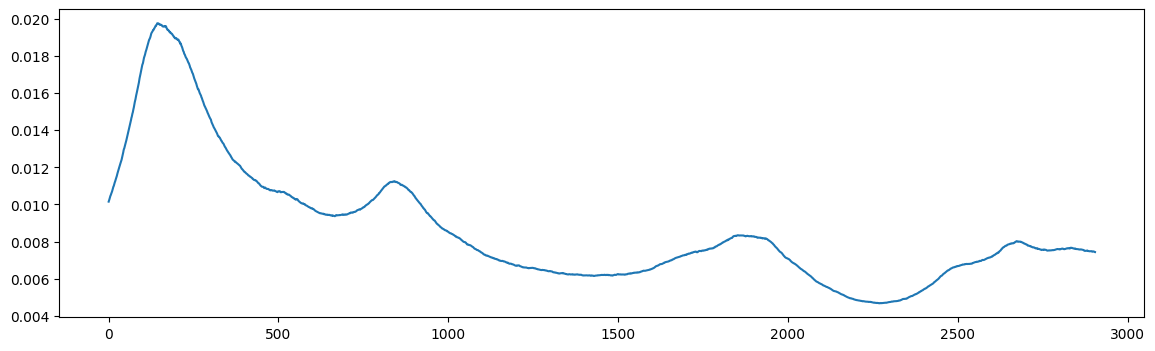

# 2022-10-15

* Fixed: Prior should not be multiplied by len(trace) because $P(X,Y|Z)P(Z) = P(X|Z) P(Y|Z)P(Z)$ where $X$ and $Y$ are conditionally independent given $Z$.  So we only need on prior ($Z$) not one for each of $X,Y$
* Did more debugging, seems like instability in gradient is causing some of my problems
    * See the gradient on sigma blows up for some reason.  Maybe this is like the RNN kind of problem with gradient instability and long traces (we do have a trace of ~3000)

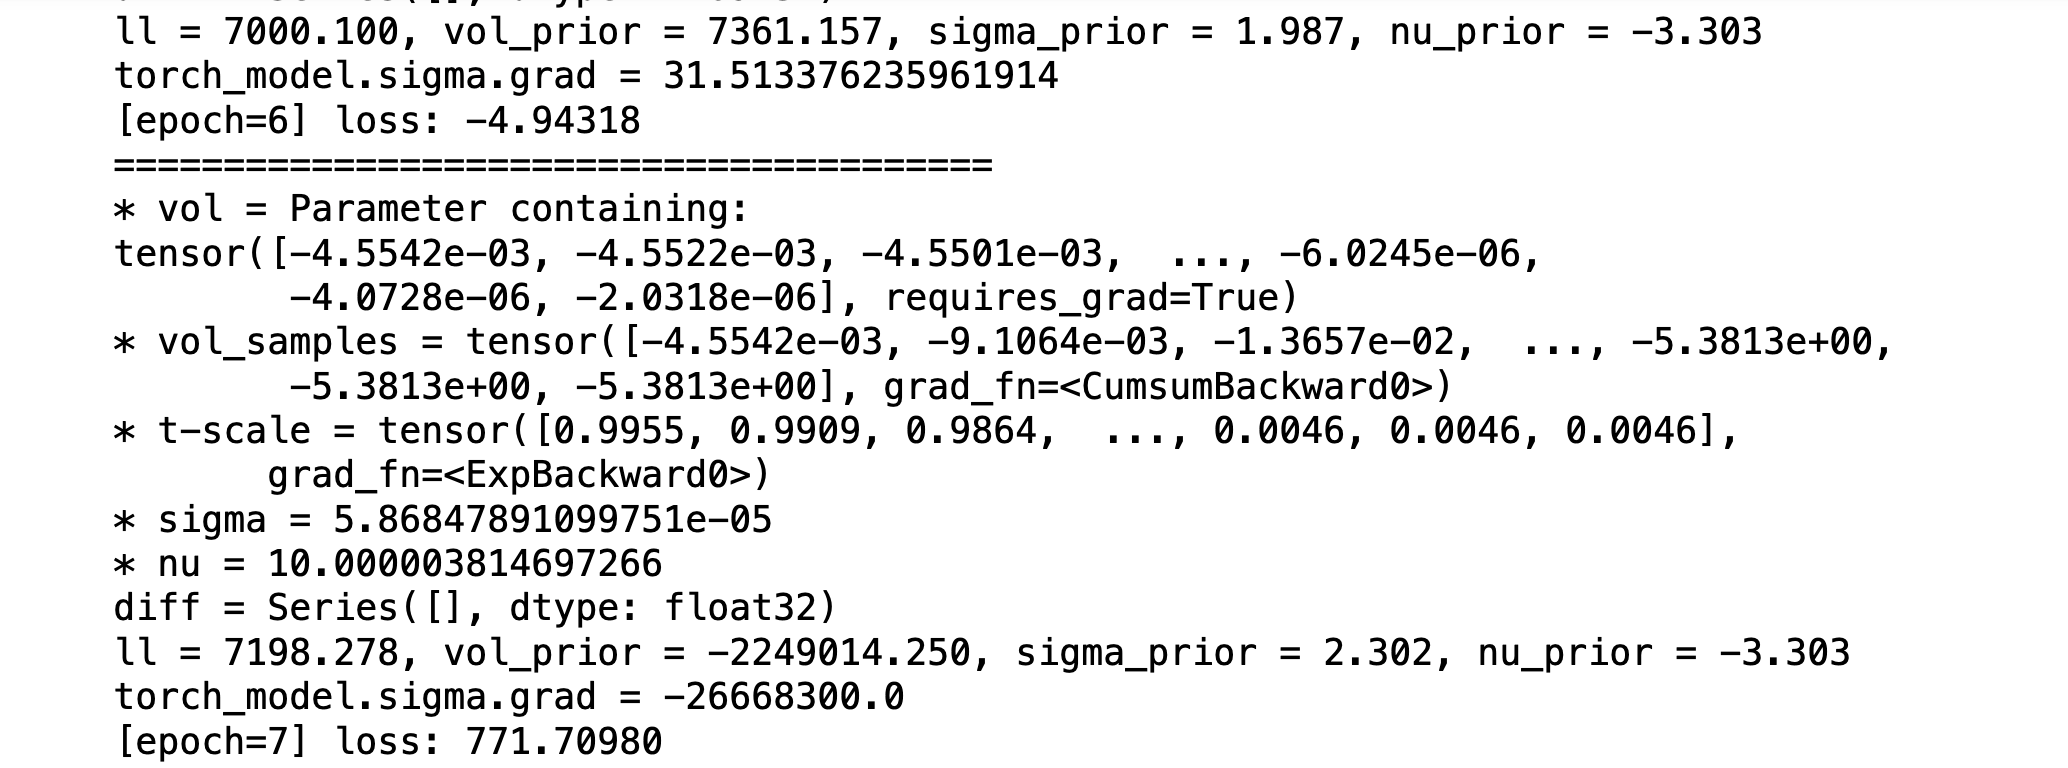

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...